In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

(1080, 1920)


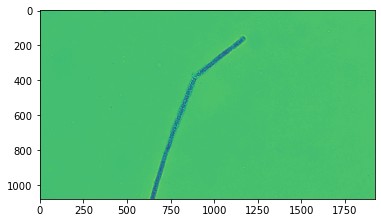

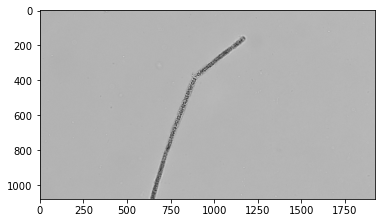

In [2]:
imageNames = ["planktothrix_80_6h_19.tif", "planktothrix_80_6h_32.tif", "planktothrix_before_22.tif", "planktothrix_before_23.tif"]
img = cv2.imread(imageNames[0],0)
print(img.shape)
normalizedImg = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
img = normalizedImg
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
plt.imshow(img_rgb)
plt.show()

**High Pass Filter**

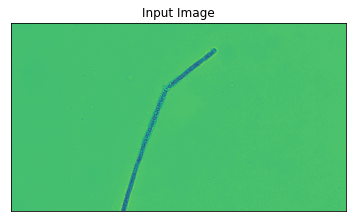

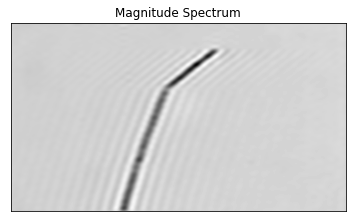

In [3]:
def hp_filter(img):
    img_float32 = np.float32(img)

    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow, ccol = int(rows/2) , int(cols/2)     # center

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    mask2 = np.zeros((rows, cols, 2), np.uint8)
    mask2[np.where(mask == 0)] = 1
    #mask = mask2

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    return img_back

img_back = hp_filter(img)
plt.imshow(img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()                

Morphological operations

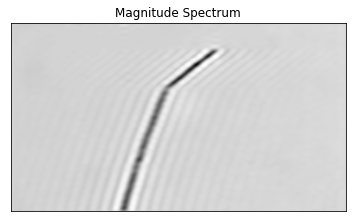

In [4]:
kernel = np.ones((5,5),np.uint8)
#kernel = [[0,0,0,0,0],[0,1,1,1,0],[0,1,2,1,0],[0,1,1,1,0],[0,0,0,0,0]]
erosion = cv2.erode(img_back,kernel,iterations = 1)
dilation = cv2.dilate(erosion,kernel,iterations = 2)
plt.imshow(dilation, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()                

(2073600,)
mean = 372570560.0
median = 374232896.0
threshold = 358556192.0


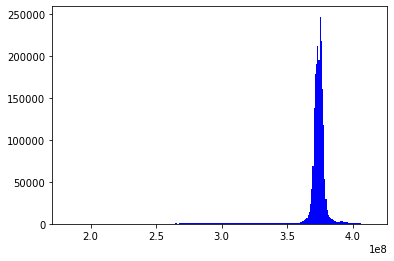

In [5]:
myData = img_back.flatten()
print(myData.shape)
numBins = 255
n, bins, patches = plt.hist(myData, numBins, facecolor='blue')
myMean = np.mean(myData)
myMedian = np.median(myData)
myStd = np.std(myData)
myThres = myMean - (myStd)
print("mean = {}".format(myMean))
print("median = {}".format(myMedian))
print("threshold = {}".format(myThres))
plt.show()

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


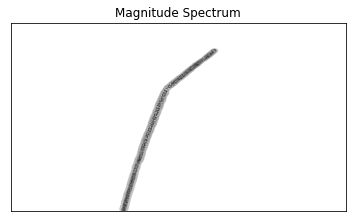

In [6]:
threshold = 3.5e+08
upper = 255
img_filtered = np.where(img_back>threshold, upper, img)
print(img_filtered)
plt.imshow(img_filtered, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()    

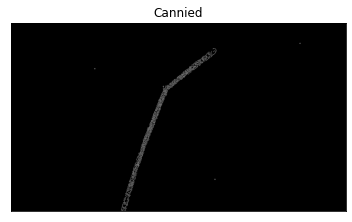

In [7]:
img_cannied = cv2.Canny(img, 100, 200)
img_cannied_rgb = cv2.cvtColor(img_cannied, cv2.COLOR_BGR2RGB)
plt.imshow(img_cannied_rgb)
plt.title('Cannied'), plt.xticks([]), plt.yticks([])
plt.show()

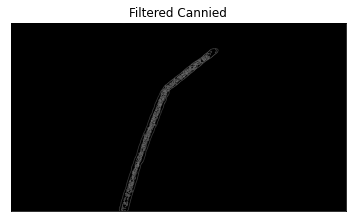

In [8]:
img_filtered_cannied = cv2.Canny(img_filtered, 256, 50, 5)
img_filtered_cannied_rgb = cv2.cvtColor(img_filtered_cannied, cv2.COLOR_BGR2RGB)
plt.imshow(img_filtered_cannied_rgb)
plt.title('Filtered Cannied'), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
def grabCut(img):
    mask = np.zeros(img.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # rect = (52, 52, 150, 150) # This was Ismael's for resized images
    #rect = (480, 270, 960, 540)
    rect = (1, 1, 1918, 1078)


    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 8, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]
    return img

In [10]:
def marker(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)

    fg = cv2.erode(thresh, kernel, iterations=1)

    bgt = cv2.dilate(thresh, kernel, iterations=1)
    ret, bg = cv2.threshold(bgt, 1, 128, 1)

    marker = cv2.add(fg, bg)

    marker32 = np.int32(marker)
    cv2.watershed(img, marker32)
    m = cv2.convertScaleAbs(marker32)
    ret, thresh = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    res = cv2.bitwise_and(img, img, mask=thresh)
    return res

fg


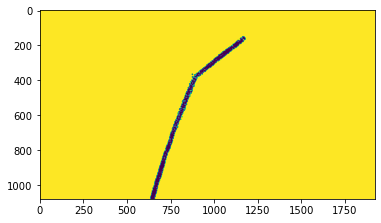

bg


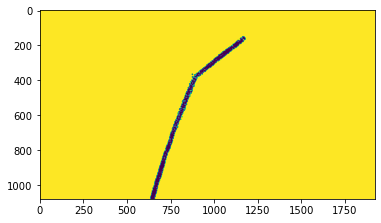

[[  0   0   0 ...   0   0   0]
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 ...
 [  0 255 255 ... 255 255   0]
 [  0 255 255 ... 255 255   0]
 [  0   0   0 ...   0   0   0]]
Watershed 2 planktothrix_before_23.tif


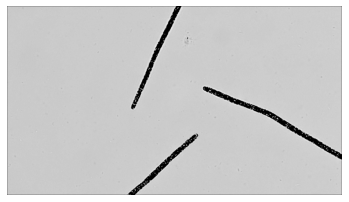

In [25]:
def marker2(img_orig):
    img=img_orig
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)

    fg = cv2.erode(thresh, kernel, iterations=1)
    print("fg")
    plt.imshow(fg)
    plt.show()

    bgt = cv2.dilate(thresh, kernel, iterations=1)
    ret, bg = cv2.threshold(bgt, 1, 128, 1)
    print("bg")
    plt.imshow(fg)
    plt.show()


    marker = cv2.add(fg, bg)

    marker32 = np.int32(marker)
    cv2.watershed(img, marker32)
    m = cv2.convertScaleAbs(marker32)
    ret, thresh = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print(thresh)
    antiThresh = thresh
    antiThresh[antiThresh == 0] = 1
    antiThresh[antiThresh == 255] = 0
    antiThresh[antiThresh == 1] = 255
    #print(antiThresh)
    zeros = np.zeros(img_orig.shape, dtype=img_orig.dtype)
    res = cv2.bitwise_and(img_orig, zeros, mask=antiThresh)
    img[thresh == 0] = 0
    res = img
    return res

img = cv2.imread("planktothrix_80_6h_19.tif",0)
normalizedImg = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
img = normalizedImg
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_w2 = marker2(img_rgb)
img_w2_rgb = cv2.cvtColor(img_w, cv2.COLOR_BGR2RGB)
print("Watershed 2 {}".format(i))
plt.axis('off')
plt.imshow(img_w_rgb)
plt.savefig("{}_watershed2.png".format(i), bbox_inches='tight')
plt.show()



Normalised image planktothrix_80_6h_19.tif


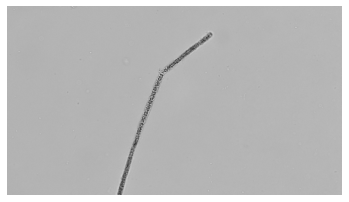

High pass image planktothrix_80_6h_19.tif


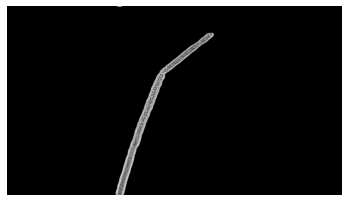

Morphological planktothrix_80_6h_19.tif


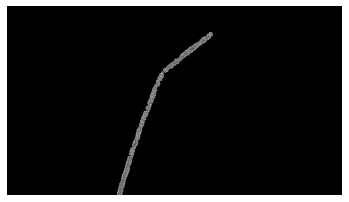

GrabCut planktothrix_80_6h_19.tif


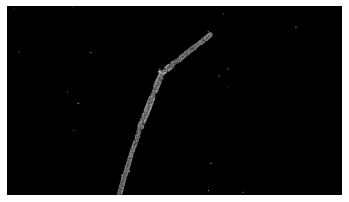

Watershed planktothrix_80_6h_19.tif


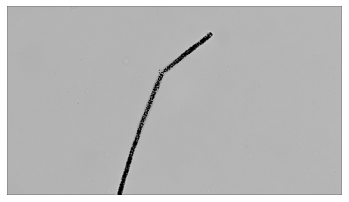

Canny planktothrix_80_6h_19.tif


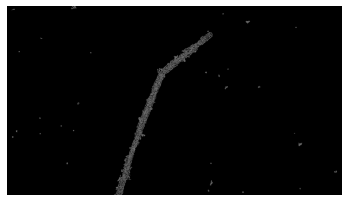

Normalised image planktothrix_80_6h_32.tif


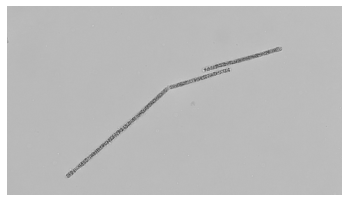

High pass image planktothrix_80_6h_32.tif


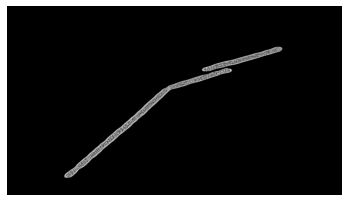

Morphological planktothrix_80_6h_32.tif


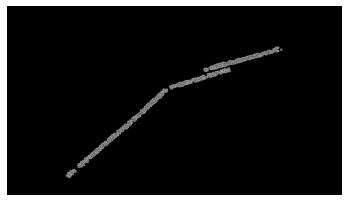

GrabCut planktothrix_80_6h_32.tif


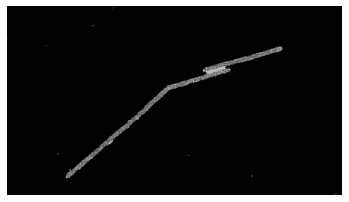

Watershed planktothrix_80_6h_32.tif


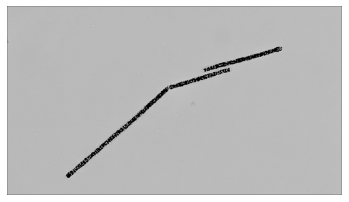

Canny planktothrix_80_6h_32.tif


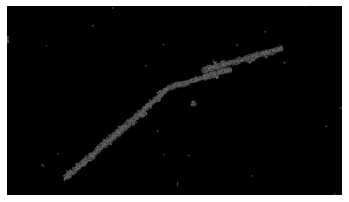

Normalised image planktothrix_before_22.tif


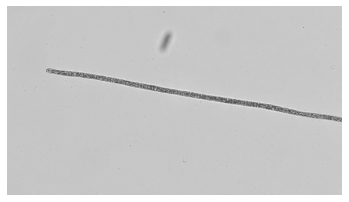

High pass image planktothrix_before_22.tif


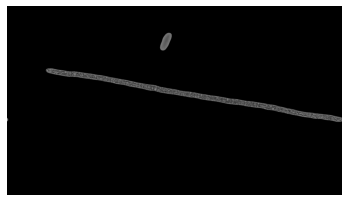

Morphological planktothrix_before_22.tif


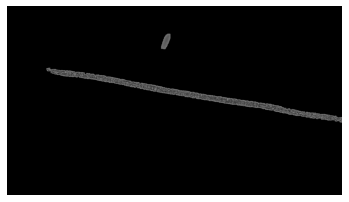

GrabCut planktothrix_before_22.tif


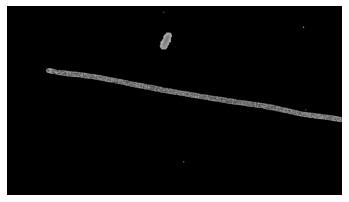

Watershed planktothrix_before_22.tif


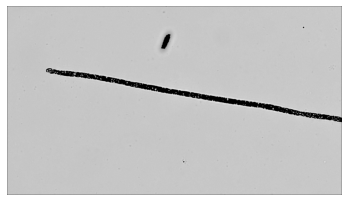

Canny planktothrix_before_22.tif


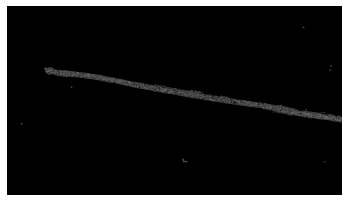

Normalised image planktothrix_before_23.tif


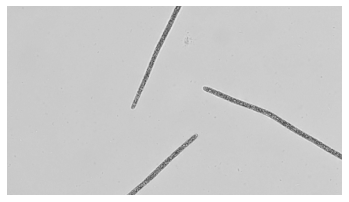

High pass image planktothrix_before_23.tif


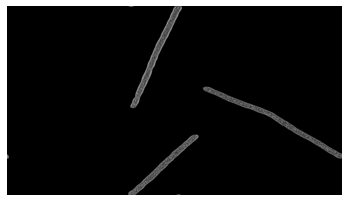

Morphological planktothrix_before_23.tif


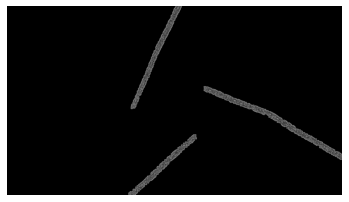

GrabCut planktothrix_before_23.tif


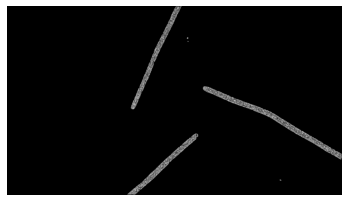

Watershed planktothrix_before_23.tif


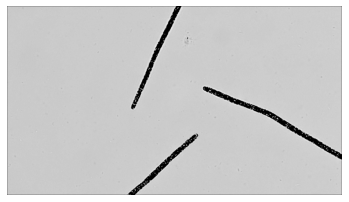

Canny planktothrix_before_23.tif


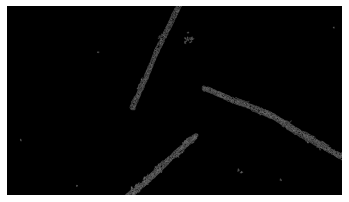

In [26]:
def customFilter(img):
    img_back = hp_filter(img)
    myData = img_back.flatten()
    threshold = 3.5e+08
    myMean = np.mean(myData)
    myStd = np.std(myData)
    myThres = myMean - (2*myStd)
    threshold = myThres
    upper = 0
    img_filtered = np.where(img_back>threshold, upper, img)
    return img_filtered

def customFilter2(img):
    gray = img
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    upper = 0
    img_filtered = np.where(sure_bg==0, upper, img)
    return img_filtered


imageNames = ["planktothrix_80_6h_19.tif", "planktothrix_80_6h_32.tif", "planktothrix_before_22.tif", "planktothrix_before_23.tif"]
for i in imageNames:
    img = cv2.imread(i,0)
    normalizedImg = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
    #img = normalizedImg
    img_rgb = cv2.cvtColor(normalizedImg, cv2.COLOR_BGR2RGB)
    print("Normalised image {}".format(i))
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.savefig("{}_normalised.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_normalised.png".format(i), img_rgb)
    img_f = customFilter(img)
    img_f_rgb = cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB)
    print("High pass image {}".format(i))
    plt.axis('off')
    plt.imshow(img_f_rgb)
    plt.savefig("{}_highpassed.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_highpassed.png".format(i), img_f_rgb)
    img_f2 = customFilter2(img)
    img_f2_rgb = cv2.cvtColor(img_f2, cv2.COLOR_BGR2RGB)
    print("Morphological {}".format(i))
    plt.axis('off')
    plt.imshow(img_f2_rgb)
    plt.savefig("{}_morphological.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_morphological.png".format(i), img_f2_rgb)
    img_g = grabCut(img_rgb)
    img_g_rgb = cv2.cvtColor(img_g, cv2.COLOR_BGR2RGB)
    print("GrabCut {}".format(i))
    plt.axis('off')
    plt.imshow(img_g_rgb)
    plt.savefig("{}_grabcut.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_grabcut.png".format(i), img_g_rgb)
    img_w = marker(img_rgb)
    img_w_rgb = cv2.cvtColor(img_w, cv2.COLOR_BGR2RGB)
    print("Watershed {}".format(i))
    plt.axis('off')
    plt.imshow(img_w_rgb)
    plt.savefig("{}_watershed.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_watershed.png".format(i), img_w_rgb)

    
    img_cannied = cv2.Canny(img, 10, 70, 3)
    img_c_rgb = cv2.cvtColor(img_cannied, cv2.COLOR_BGR2RGB)
    print("Canny {}".format(i))
    plt.axis('off')
    plt.imshow(img_c_rgb)
    plt.savefig("{}_Canny.png".format(i), bbox_inches='tight')
    plt.show()
    cv2.imwrite("{}_Canny.png".format(i), img_c_rgb)




    

In [ ]:
# watershed
img3 = cv2.imread(imageNames[0],0)
img2 = np.uint8(img_rgb)

def markersFromImage(img):
    # First pass, just have "mark" the corners
    img2 = np.uint8(img)
    markers = np.zeros(img2.shape, img2.dtype)
    markers[0][0] = 255
    markers[0][img2.shape[1]-1] = 255
    markers[img2.shape[0]-1][0] = 255
    markers[img2.shape[0]-1][img2.shape[1]-1] = 255
    gray = cv2.cvtColor(markers, cv2.COLOR_BGR2GRAY)
    mymarkers = np.int32(gray)
    return mymarkers

#markers = cv2.fromarray(markers)
def markersFromImage2(img):
    gray = cv2.cvtColor(img_filtered_cannied_rgb, cv2.COLOR_BGR2GRAY)
    print(gray)
    mymarkers = np.int32(gray)
    return mymarkers

def markersFromImage3(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    print("After noise removal")
    plt.imshow(opening)
    plt.show()    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    print("Sure background (after dilation)")
    plt.imshow(sure_bg)
    plt.show()  
    print(np.unique(sure_bg))


    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
    
    print("Sure foreground (after dilation)")
    plt.imshow(sure_fg)
    plt.show()    


    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    return markers


mymarkers = markersFromImage3(img_rgb)
#img_rgb2 = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
print(img2.shape)
print(mymarkers.shape)
im_wshed = cv2.watershed(img2, mymarkers)
plt.imshow(img_rgb)
plt.show()
plt.imshow(im_wshed)
plt.show()

In [67]:
def processImage5(inFile, outDir):
    d, b = os.path.split(inFile)
    outName = os.path.join(outDir, b)
    im = cv2.imread(inFile, 0)
    im_wshed = cv2.watershed(im, markers)
    size = 128, 128
    resized = cv2.resize(im_wshed, size, interpolation=cv2.INTER_LANCZOS4)
    cv2.imwrite(outName, resized)


def markers(img):
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])

    gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # noise removal
    kernel = np.ones((2, 2), np.uint8)
    # opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

   # sure background area
    sure_bg = cv2.dilate(closing, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)

    # Threshold
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    return markers